# TP1: Classifieur linéaire, fonction de perte **Entropie croisée**

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)
    X_batch -= np.mean(X_batch, axis = 0)

    # Ajout du biais
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    X_batch = np.hstack([X_batch, np.ones((X_batch.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)


## Question 1

Les prochaines étapes consistent à implanter le calcul de **l'entropie croisée** et de son **gradient**.   Vous commencerez avec une version naïve impliquant une boucle *for* sur l'ensemble des éléments d'une batch pour ensuite implanter une version vectorisée.   Mais avant de commencer à coder, veuillez donner ici la formule de l'entropie croisée et du gradient pour une mini-batch de 500 données contenue dans le tableau

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = ....$$

$$dW = ....$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et vectorielles

## Classifieur linéaire SOFTMAX

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `softmax_ce_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  


Commençons par tester la **forward pass + l'entropie croisée**.  Pour l'instant, ignorons la rétro-propagation.

In [6]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.276854
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [7]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction softmax_ce_naive_forward_backward située dans le fichier      #
#  utils.loss.                                                               #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 2.356459
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 2:
Pourquoi s'attend-on que la loss soit approximativement -np.log(1/nb_classes))?



**Votre réponse:**

Etant donné que le model prédit les probalités d'appartenance à une classe et que le model n'est pas entrainé, toute les classe ont approximativement la même probalité d'être la classe d'appartenance de l'exemple  $x_i$ fourni en entrée. D'où $P(c_i| x_i) = \frac{1}{C}$

In [8]:
###################################################################################
#  Vérification simple: s'assurer que l'entropie-croisée soit proche de           #
#  -log(1/nb_classes)                                                             #
###################################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données 
W = np.random.randn(3073, 10) * 1e-4
loss, _ = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss d'un modèle non-entrainé devrait s'approcher de -log(0.1).
print('Softmax loss: %f' % loss)
print('Sanity check: %f' % (-np.log(0.1)))

Softmax loss: 2.339132
Sanity check: 2.302585


## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [9]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = softmax_ce_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 2.30114875
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-0.1279744 ,  1.15786877, -0.12847105])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [10]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       softmax_ce_naive_forward_backward située dans le fichier utils.loss  #
#                                                                            #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

from utils.loss import softmax_ce_naive_forward_backward
import time

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = softmax_ce_naive_forward_backward(X_batch, W, y_batch, 0.0)
print(dW[0,0:4])
# La loss suivante est celle que vous devriez obtenir
target_loss = 2.35680883
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-1.68817739, -1.37204569, -0.46158773, 1.9206649])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

[-1.68817739 -1.37204569 -0.46158773  1.9206649 ]
Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de l'entropie croisée (et de son gradient) via la fonction *softmax_ce_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le teste du **gradient numérique**

In [11]:
##############################################################################
# Vérifions que le fait d'augmenter le terme de régularisation L2            #
# augmente la loss...                                                        #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = softmax_ce_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.2
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


2.3833318596237225
2.386399864475836
2.390081470298373
2.3944993972854167
2.3998009096698696
2.406162724531213
2.4137969023648247
2.422957915765159
2.4339511318455602
2.4471429911420417
Bravo!


In [12]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(softmax_ce_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: 1.110891, analytic 1.110891, relative error: 3.006790e-11
numerical: -0.179328, analytic -0.179328, relative error: 2.131052e-09
numerical: -0.982575, analytic -0.982575, relative error: 4.839279e-10
numerical: -1.145420, analytic -1.145420, relative error: 1.224126e-10
numerical: -0.027805, analytic -0.027805, relative error: 2.002629e-08
numerical: 0.205056, analytic 0.205056, relative error: 1.833562e-09
numerical: 1.873449, analytic 1.873449, relative error: 4.806517e-11
numerical: -2.104024, analytic -2.104024, relative error: 3.092439e-10
numerical: 0.382450, analytic 0.382450, relative error: 1.143871e-10
numerical: -0.067706, analytic -0.067706, relative error: 4.282365e-10

------------
Gradient check : reg=1e-2
------------

numerical: 0.860354, analytic 0.860354, relative error: 1.647541e-09
numerical: 2.018536, analytic 2.018536, relative error: 5.581393e-10
numerical: 0.934964, analytic 0.934964, relative error:

## Softmax et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **softmax_ce_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

In [17]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction softmax_ce_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
start = time.time()
loss_naive, grad_naive = softmax_ce_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import softmax_ce_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = softmax_ce_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 2.367992e+00 computed in 0.085233s
vectorized loss: 2.367992e+00 computed in 0.002772s
bravo pour la loss!
Loss difference: 0.000000
bravo pour le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** ainsi que de la fonction vectorisée **softmax_ce_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

train vs val acc 0.279429 / 0.2920007055865


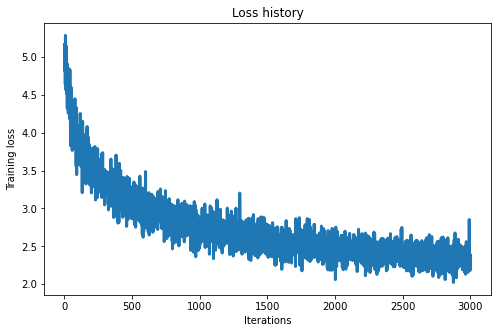

In [18]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 1

classifier = LinearClassifier(softmax_ce_forward_backward)
#
# TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
#
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

best validation accuracy achieved during cross-validation: 0.409000


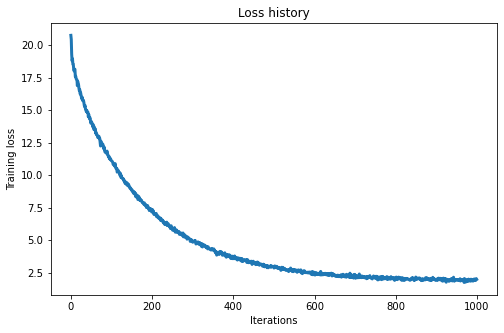

In [23]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(1e-7, 1e-5, 5)
regularization_strengths = np.linspace(1e3, 1e7, 5)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 1000    #
#  vous devriez obtenir une précision de classification supérieur à 0.38 sur #
#  l'ensemble de validation, et de 0.37 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################
index = 1
for lr, reg in it.product(learning_rates, regularization_strengths):
        classifier = LinearClassifier(softmax_ce_forward_backward)
        train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=1000, verbose = True)
        y_val_pred = classifier.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        if acc_val > best_val:
            best_loss_history = train_loss_history
            best_lr = lr
            best_reg = reg
            best_val = acc_val
            best_classifier = classifier
        results[f'Model : {index}'] = dict(reg = reg, lr = lr, classifier = classifier, train_loss_history = train_loss_history)
        index +=1

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [24]:
# On évalue le modèle sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Test set accuracy: %f' % (test_accuracy) )

Test set accuracy: 0.378000


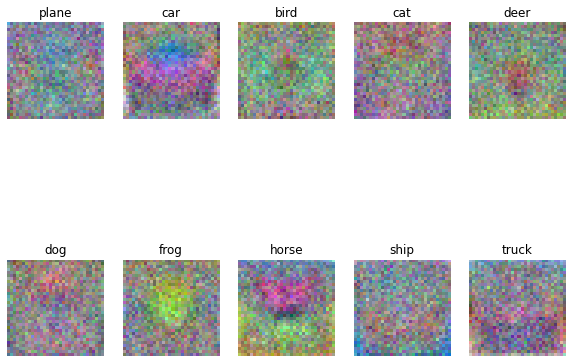

In [22]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])